In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop_generator_protein_layer_norm import *
from seqprop.predictor import *
from seqprop.optimizer import *

from seqprop_protein_utils import *
from seqprop_rosetta_kl_helper import _get_kl_divergence_numpy, _get_smooth_kl_divergence_numpy, _get_smooth_circular_kl_divergence_numpy
from seqprop_rosetta_kl_helper import _get_kl_divergence_keras, _get_smooth_kl_divergence_keras, _get_smooth_circular_kl_divergence_keras
from basinhopping_rosetta import *

from definitions.trrosetta_single_model_no_msa_batched_simpler_1d_features_2 import load_saved_predictor

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_kl_loss(target_p_dist, target_p_theta, target_p_phi, target_p_omega) :
    
    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs
        
        kl_dist, kl_theta, kl_phi, kl_omega = _get_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        kl_dist, kl_theta, kl_phi, kl_omega = _get_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func_smooth_kl(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        kl_dist, kl_theta, kl_phi, kl_omega = _get_smooth_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func_smooth_circular_kl(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        kl_dist, kl_theta_sin, kl_theta_cos, kl_phi, kl_omega_sin, kl_omega_cos = _get_smooth_circular_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, target_p_dist, target_p_theta, target_p_phi, target_p_omega)
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta_sin + kl_theta_cos + kl_phi + kl_omega_sin + kl_omega_cos, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func, val_loss_func_smooth_kl, val_loss_func_smooth_circular_kl


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)


class DummyValidationCallback(Callback):
    def __init__(self, val_name) :
        self.val_name = val_name
        
        self.val_loss_history = []

class DummyFlexibleSeqPropMonitor(Callback):
    def __init__(self, measure_name='Measure') :
        self.measure_name = measure_name
        self.measure_history = [] = []
        self.entropy_history = []
        self.nt_swap_history = []
        self.prev_optimized_pwm = None

        self.n_epochs = 0

def _tmp_load_model(model_path) :

    saved_model = load_model(model_path, custom_objects = {
        'InstanceNormalization' : InstanceNormalization,
        'reweight' : reweight,
        'wmin' : 0.8,
        'msa2pssm' : msa2pssm,
        'tf' : tf,
        'fast_dca' : fast_dca,
        'keras_collect_features' : keras_collect_features
    })
    
    return saved_model


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(loss_funcs, val_loss_funcs, val_loss_funcs_smooth_kl, val_loss_funcs_smooth_circular_kl, transform_funcs, temperature_params, t_distos, msa_one_hots, seq_length=100, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100, logit_init_mode='glorot_uniform', optimizer=None) :
    
    if eval_mode == 'basinhopping' :
        residues = list("ARNDCQEGHILKMFPSTWYV")
        residue_map = {
            residue : residue_ix
            for residue_ix, residue in enumerate(residues)
        }
        acgt_encoder = IdentityEncoder(seq_length, residue_map)
        
        predictor = _tmp_load_model(model_path)
        predictor.compile(
            loss='mse',
            optimizer=keras.optimizers.SGD(lr=0.1)
        )
        
        n_iters_per_temperate, n_swaps, t_init, t_func = temperature_params[0]
        
        evolved_sequences, evolved_scores, evolved_scores_smooth_kl, evolved_scores_smooth_circular_kl = run_simulated_annealing_batch(predictor, t_distos, msa_one_hots[0], "$" * seq_length, acgt_encoder, n_sequences=n_sequences, n_iters=steps_per_epoch, n_iters_per_temperate=n_iters_per_temperate, temperature_init=t_init, temperature_func=t_func, n_swaps=n_swaps, verbose=False)
        evolved_losses = -evolved_scores
        evolved_losses_smooth_kl = -evolved_scores_smooth_kl
        evolved_losses_smooth_circular_kl = -evolved_scores_smooth_circular_kl
        
        train_history = DummyValidationCallback('loss')
        train_history.val_loss_history = np.mean(evolved_losses * n_sequences, axis=0).tolist()
        
        valid_history = DummyValidationCallback('val_loss')
        valid_history.val_loss_history = np.mean(evolved_losses, axis=0).tolist()
        
        valid_history_smooth_kl = DummyValidationCallback('val_loss_smooth_kl')
        valid_history_smooth_kl.val_loss_history = np.mean(evolved_losses_smooth_kl, axis=0).tolist()
        
        valid_history_smooth_circular_kl = DummyValidationCallback('val_loss_smooth_circular_kl')
        valid_history_smooth_circular_kl.val_loss_history = np.mean(evolved_losses_smooth_circular_kl, axis=0).tolist()
        
        opt_pwm = np.expand_dims(np.expand_dims(acgt_encoder.encode(evolved_sequences[0]), axis=-1), axis=0)
        
        return [opt_pwm], [train_history], [valid_history], [valid_history_smooth_kl], [valid_history_smooth_circular_kl]
    
    n_objectives = len(loss_funcs)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    valid_histories_smooth_kl = []
    valid_histories_smooth_circular_kl = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        val_loss_func_smooth_kl = val_loss_funcs_smooth_kl[obj_ix]
        val_loss_func_smooth_circular_kl = val_loss_funcs_smooth_circular_kl[obj_ix]
        transform_func = transform_funcs[obj_ix]
        msa_one_hot = msa_one_hots[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample', logit_init_mode=logit_init_mode)
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_valid_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='max', master_generator=seqprop_generator, logit_init_mode=logit_init_mode)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        _, valid_loss_model_smooth_kl = build_loss_model(valid_predictor, val_loss_func_smooth_kl)
        _, valid_loss_model_smooth_circular_kl = build_loss_model(valid_predictor, val_loss_func_smooth_circular_kl)
        
        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=optimizer)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        valid_history_smooth_kl = ValidationCallback('val_loss_smooth_kl', valid_loss_model_smooth_kl, 1)
        valid_history_smooth_circular_kl = ValidationCallback('val_loss_smooth_circular_kl', valid_loss_model_smooth_circular_kl, 1)
        
        callbacks =[
            train_history,
            valid_history,
            valid_history_smooth_kl,
            valid_history_smooth_circular_kl
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        valid_history_smooth_kl.val_loss_model = None
        valid_history_smooth_circular_kl.val_loss_model = None
        
        _, opt_pwm, _, _, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        seqprop_predictors.append(opt_pwm)
        train_histories.append(train_history)
        valid_histories.append(valid_history)
        valid_histories_smooth_kl.append(valid_history_smooth_kl)
        valid_histories_smooth_circular_kl.append(valid_history_smooth_circular_kl)

    return seqprop_predictors, train_histories, valid_histories, valid_histories_smooth_kl, valid_histories_smooth_circular_kl


In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), 'trRosetta/network/model2019_07')
model_name = 'model.xaa_batched_no_drop_2.h5'
model_path = os.path.join(save_dir, model_name)


In [4]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


(1, 1, 72, 21)
(1, 72, 72, 37)


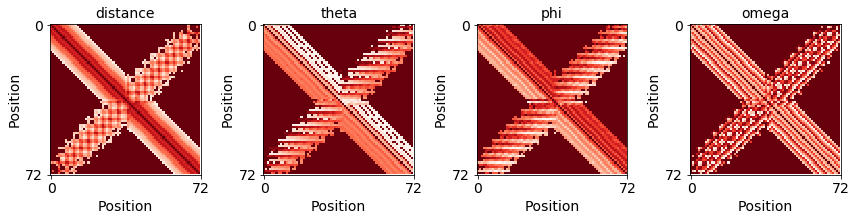

In [5]:
msa_file = "trRosetta/example/TR005257.a3m"

fig_name = "TR005257"
save_figs = False

a3m = parse_a3m(msa_file)

msa_one_hot = np.expand_dims(one_hot_encode_msa(a3m), axis=0)[:, :1, ...]

print(msa_one_hot.shape)

npz_file = "trRosetta/example/TR005257_xaa_corrected.npz"

npz_data = np.load(npz_file)

t_pd, t_pt, t_pp, t_po = npz_data['dist'], npz_data['theta'], npz_data['phi'], npz_data['omega']

print(t_pd.shape)


f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [t_pd, 'distance', ax_list[0]],
    [t_pt, 'theta', ax_list[1]],
    [t_pp, 'phi', ax_list[2]],
    [t_po, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_t_distribs.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_t_distribs.svg')
    plt.savefig(fig_name + '_t_distribs.eps')

plt.show()



In [ ]:

seeds = [1177, 14755, 74662, 112110, 252654]

#Run SeqProp Optimization

print("Running optimization experiment 'trRosetta Target Structure'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Sequence length
seq_length = msa_one_hot.shape[2]
#Number of steps (grad updates) per epoch
steps_per_epoch = 200
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 1

experiment_name_list = [
    'Basinhopping 1/0.001',
    'Basinhopping 1/0.01',
    'Basinhopping 1/0.1',
    'Basinhopping 1/1.0',
    
    'Sampled (Adam 0.001 0.9/0.999)',
    'Sampled (Adam 0.01 0.5/0.9)',
    
    'Sampled-IN (Adam 0.001 0.9/0.999)',
    'Sampled-IN (Adam 0.01 0.5/0.9)'
]

eval_mode_list = [
    'basinhopping',
    'basinhopping',
    'basinhopping',
    'basinhopping',
    
    'sample',
    'sample',
    
    'sample',
    'sample'
]

normalize_logits_list = [
    False,
    False,
    False,
    False,
    
    False,
    False,
    
    True,
    True
]

n_samples_list = [
    1,
    1,
    1,
    1,
    
    1,
    1,
    
    1,
    1
]

temperature_params_list = [
    [10, 1, 0.001, lambda t, curr_iter, t_init=0.001, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    [10, 1, 0.01, lambda t, curr_iter, t_init=0.01, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    [10, 1, 0.1, lambda t, curr_iter, t_init=0.1, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    [10, 1, 1.0, lambda t, curr_iter, t_init=1.0, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    
    [None, None, None, None],
    [None, None, None, None],
    
    [None, None, None, None],
    [None, None, None, None]
]

logit_init_modes = [
    '',
    '',
    '',
    '',
    
    'glorot_uniform',
    'glorot_uniform',
    
    'glorot_uniform',
    'glorot_uniform'
]

optimizers = [
    lambda x: None,
    lambda x: None,
    lambda x: None,
    lambda x: None,
    
    lambda x: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    lambda x: keras.optimizers.Adam(lr=0.01, beta_1=0.5, beta_2=0.9),
    
    lambda x: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    lambda x: keras.optimizers.Adam(lr=0.01, beta_1=0.5, beta_2=0.9),
]

result_dict = {
    'Basinhopping 1/0.001' : {},
    'Basinhopping 1/0.01' : {},
    'Basinhopping 1/0.1' : {},
    'Basinhopping 1/1.0' : {},
    
    'Sampled (Adam 0.001 0.9/0.999)' : {},
    'Sampled (Adam 0.01 0.5/0.9)' : {},
    
    'Sampled-IN (Adam 0.001 0.9/0.999)' : {},
    'Sampled-IN (Adam 0.01 0.5/0.9)' : {},
}

for experiment_name, eval_mode, normalize_logits, n_samples, temperature_params, logit_init_mode, optimizer_func in zip(experiment_name_list, eval_mode_list, normalize_logits_list, n_samples_list, temperature_params_list, logit_init_modes, optimizers) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    for rand_seed_ix, rand_seed in enumerate(seeds) :
    
        print("Running seed " + str(rand_seed_ix) + "...")

        K.clear_session()
        
        optimizer = optimizer_func(None)

        set_seed(rand_seed)

        losses, val_losses, val_losses_smooth_kl, val_losses_smooth_circular_kl = zip(*[
            get_kl_loss(
                t_pd,
                t_pt,
                t_pp,
                t_po
            )
        ])

        transforms = [
            None
        ]

        opt_pwms, train_histories, valid_histories, valid_histories_smooth_kl, valid_histories_smooth_circular_kl = run_seqprop(losses, val_losses, val_losses_smooth_kl, val_losses_smooth_circular_kl, transforms, [temperature_params], [t_pd, t_pt, t_pp, t_po], [msa_one_hot], seq_length, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch, logit_init_mode, optimizer)

        opt_pwm, train_history, valid_history, valid_history_smooth_kl, valid_history_smooth_circular_kl = opt_pwms[0], train_histories[0], valid_histories[0], valid_histories_smooth_kl[0], valid_histories_smooth_circular_kl[0]

        if rand_seed_ix > 0 :
            result_dict[experiment_name]['train_history'].val_loss_history.append(train_history.val_loss_history)
            result_dict[experiment_name]['valid_history'].val_loss_history.append(valid_history.val_loss_history)
            result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history.append(valid_history_smooth_kl.val_loss_history)
            result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history.append(valid_history_smooth_circular_kl.val_loss_history)
            
        else :
            train_history.val_loss_history = [train_history.val_loss_history]
            valid_history.val_loss_history = [valid_history.val_loss_history]
            valid_history_smooth_kl.val_loss_history = [valid_history_smooth_kl.val_loss_history]
            valid_history_smooth_circular_kl.val_loss_history = [valid_history_smooth_circular_kl.val_loss_history]
            
            result_dict[experiment_name] = {
                'opt_pwm' : opt_pwm,
                'train_history' : train_history,
                'valid_history' : valid_history,
                'valid_history_smooth_kl' : valid_history_smooth_kl,
                'valid_history_smooth_circular_kl' : valid_history_smooth_circular_kl
            }
    
    result_dict[experiment_name]['train_history'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['train_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['valid_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history_median = np.median(np.array(result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history), axis=0).tolist()
    
    result_dict[experiment_name]['train_history'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['train_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['valid_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history_mean = np.mean(np.array(result_dict[experiment_name]['valid_history_smooth_circular_kl'].val_loss_history), axis=0).tolist()


In [10]:

for experiment_name in result_dict :
    for loss_str in result_dict[experiment_name] :
        if 'model' in dir(result_dict[experiment_name][loss_str]) :
            result_dict[experiment_name][loss_str].model = None


In [11]:
import pickle

pickle.dump({'result_dict' : result_dict}, open("eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_kl_experiment_200_updates_5_seeds_with_multisample_layer_norm_no_drop_results_part_1.pickle", "wb"))


In [6]:
import pickle

#Parameters used
n_sequences = 1
n_epochs = 1
seq_length = msa_one_hot.shape[2]
steps_per_epoch = 200
n_valid_samples = 1

result_dict_part_1 = pickle.load(open("eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_kl_experiment_200_updates_5_seeds_with_multisample_layer_norm_no_drop_results_part_1.pickle", "rb"))['result_dict']
result_dict_part_2 = pickle.load(open("eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_kl_experiment_200_updates_5_seeds_with_multisample_layer_norm_no_drop_results_part_2_collapsed_steps.pickle", "rb"))['result_dict']


In [7]:

result_dict = result_dict_part_1

for result_dict_part_2_key in result_dict_part_2 :
    if result_dict_part_2_key not in result_dict :
        result_dict[result_dict_part_2_key] = result_dict_part_2[result_dict_part_2_key]


In [9]:
#Load trRosetta predictor

ckpt = "trRosetta/network/model2019_07/model.xaa_batched_no_drop_2"

saved_predictor = load_model(ckpt + ".h5", custom_objects = {
    'InstanceNormalization' : InstanceNormalization,
    'reweight' : reweight,
    'wmin' : 0.8,
    'msa2pssm' : msa2pssm,
    'tf' : tf,
    'fast_dca' : fast_dca,
    'keras_collect_features' : keras_collect_features
})


In [10]:
#Helper function for plotting results

def plot_results(saved_predictor, result_dict, t_vals, experiment_name_list, n_epochs, steps_per_epoch, loss_suffix='', fig_prefix='default', save_figs=False, figsize=(12, 4), aggregate_mode='mean', min_loss_val=0.5, max_loss_val=4.0, legend_outside=True, plot_individual_trajectories=True) :
    
    alphabet_order = "ARNDCQEGHILKMFPSTWYV"#"-"
    inv_residue_map = {
        map_key : map_val for map_key, map_val in enumerate(alphabet_order)
    }
    
    _loss_func = _get_kl_divergence_numpy
    if loss_suffix == '_smooth_kl' :
        _loss_func = _get_smooth_kl_divergence_numpy
    elif loss_suffix == '_smooth_circular_kl' :
        _loss_func = _get_smooth_circular_kl_divergence_numpy
    
    t_pd, t_pt, t_pp, t_po = t_vals
    
    if plot_individual_trajectories :
        for experiment_ix, experiment_name in enumerate(experiment_name_list) :

            print("Experiment name = " + str(experiment_name))

            opt_pwm = result_dict[experiment_name]['opt_pwm']
            train_history = result_dict[experiment_name]['train_history']
            valid_history = result_dict[experiment_name]['valid_history' + loss_suffix]

            train_traj = train_history.val_loss_history_median
            valid_traj = valid_history.val_loss_history_median
            if aggregate_mode == 'mean' :
                train_traj = train_history.val_loss_history_mean
                valid_traj = valid_history.val_loss_history_mean

            #Store statistics for optimized sequences

            fig_name = fig_prefix + experiment_name.replace(" ", "_").replace("/", "-").replace(".", "_").replace("(", "_").replace(")", "_") if save_figs else None

            f = plt.figure(figsize=(6, 4))

            n_x_coords = len(np.array(train_traj))
            x_coord_scale = (n_epochs * steps_per_epoch) / (n_x_coords - 1) #+ 1

            l1 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(train_traj) / n_sequences, color='darkgreen', linewidth=2, linestyle='-', label='Train')
            l2 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(valid_traj), color='darkorange', linewidth=2, linestyle='--', label='Valid')

            plt.xlabel("Weight Updates", fontsize=16)
            plt.ylabel("Loss", fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)

            plt.xlim(0, n_epochs * steps_per_epoch)
            plt.ylim(min(np.min(train_traj) / n_sequences, np.min(valid_traj)), max(np.max(train_traj) / n_sequences, np.max(valid_traj)))

            plt.legend(handles=[l1[0], l2[0]], fontsize=14)
            plt.tight_layout()

            if save_figs :
                plt.savefig(fig_name + '_loss.png', transparent=True, dpi=300)
                plt.savefig(fig_name + '_loss.eps')

            plt.show()

            #Print optimized sequence details

            final_kl_loss = valid_traj[-1]

            #Visualize PWM and get consensus sequence

            plot_protein_logo(inv_residue_map, opt_pwm[0, :, :, 0], "NLL", round(final_kl_loss, 2), sequence_template='$' * opt_pwm.shape[1], figsize=(12, 0.65), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=opt_pwm.shape[1])

            print(">seqprop_" + experiment_name + "_0")

            seq = ""
            for j in range(opt_pwm.shape[1]) :
                decoded_residue = inv_residue_map[int(np.argmax(opt_pwm[0, j, :, 0]))]
                seq += decoded_residue

            print(seq)

            one_hot = np.zeros((1, opt_pwm.shape[1], opt_pwm.shape[2]))
            for j in range(opt_pwm.shape[1]) :
                max_j = int(np.argmax(opt_pwm[0, j, :, 0]))
                one_hot[0, j, max_j] = 1.

            msa_one_hot = np.expand_dims(one_hot, axis=0)
            msa_one_hot = np.concatenate([msa_one_hot, np.zeros((1, 1, msa_one_hot.shape[2], 1))], axis=-1)

            pd, pt, pp, po = saved_predictor.predict(x=[one_hot, msa_one_hot], batch_size=1)

            t_dist = np.clip(t_pd, 1e-7, 1. - 1e-7)
            t_theta = np.clip(t_pt, 1e-7, 1. - 1e-7)
            t_phi = np.clip(t_pp, 1e-7, 1. - 1e-7)
            t_omega = np.clip(t_po, 1e-7, 1. - 1e-7)

            kl_div_components = list(_loss_func(pd, pt, pp, po, t_dist, t_theta, t_phi, t_omega))

            final_loss_val = np.sum(np.array(kl_div_components))

            print("final_loss_val = " + str(round(final_loss_val, 4)))

            f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

            p_list = [
                [pd, 'distance', ax_list[0]],
                [pt, 'theta', ax_list[1]],
                [pp, 'phi', ax_list[2]],
                [po, 'omega', ax_list[3]]
            ]

            for p_keras, p_name, p_ax in p_list :

                p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

                p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

                p_ax.set_title(p_name, fontsize=14)
                p_ax.set_xlabel("Position", fontsize=14)
                p_ax.set_ylabel("Position", fontsize=14)

                plt.sca(p_ax)

                plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
                plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

            plt.tight_layout()

            if save_figs :
                plt.savefig(fig_name + '_p_distribs.png', transparent=True, dpi=300)
                plt.savefig(fig_name + '_p_distribs.eps')

            plt.show()

    print("--- Comparison of loss convergence ---")

    for history_prefix in ['train', 'valid'] :

        loss_normalizer = n_sequences if history_prefix == 'train' else 1.
        y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'

        f = plt.figure(figsize=figsize)

        ls = []
        min_y_val = 1000.
        max_y_val = -1000.

        for experiment_ix, experiment_name in enumerate(experiment_name_list) :
            curr_history = result_dict[experiment_name][history_prefix + '_history' + loss_suffix] if history_prefix + '_history' + loss_suffix in result_dict[experiment_name] else result_dict[experiment_name][history_prefix + '_history']

            curr_traj = curr_history.val_loss_history_median
            if aggregate_mode == 'mean' :
                curr_traj = curr_history.val_loss_history_mean
            
            n_x_coords = len(np.array(curr_traj))
            x_coord_scale = (n_epochs * steps_per_epoch) / (n_x_coords - 1) #+ 1

            l1 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(curr_traj) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
            ls.append(l1[0])

            min_y_val = min(min_y_val, np.min(curr_traj) / loss_normalizer)
            max_y_val = max(max_y_val, np.max(curr_traj) / loss_normalizer)

        min_y_val = min_y_val - 0.05 * np.abs(min_y_val)
        max_y_val = max_y_val + 0.05 * np.abs(max_y_val)

        plt.xlabel("Weight Updates", fontsize=16)
        plt.ylabel(y_label_prefix + " Loss", fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        plt.xlim(0, n_epochs * steps_per_epoch)
        if min_loss_val is None or max_loss_val is None :
            plt.ylim(min_y_val, max_y_val)
        else :
            plt.ylim(min_loss_val, max_loss_val)

        if not legend_outside :
            plt.legend(handles=ls, fontsize=14)
        else :
            plt.legend(handles=ls, fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
            
        plt.tight_layout()

        if save_figs :
            plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=300)
            plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

        plt.show()


Experiment name = Basinhopping 1/0.001


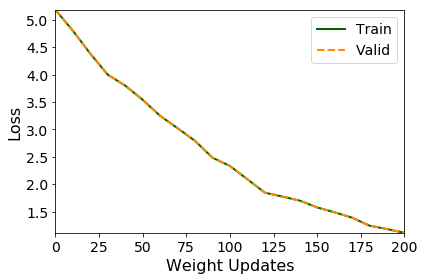

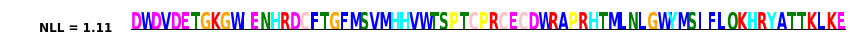

>seqprop_Basinhopping 1/0.001_0
DWDVDETGKGWIENHRDCFTGFMSVMHHVWTSPTCPRCECDWRAPRHTMLNLGWYMSIFLQKHRYATTKLKE
final_loss_val = 0.8925


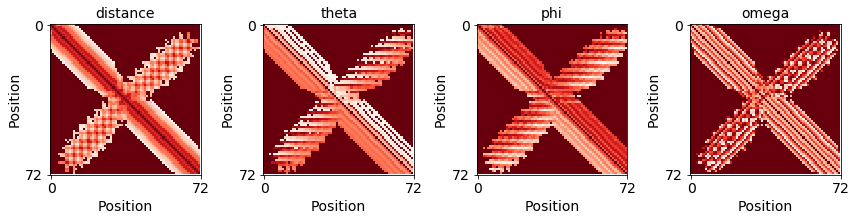

Experiment name = Basinhopping 1/0.01


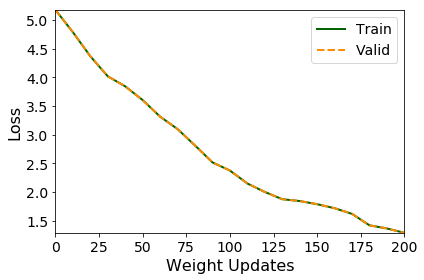

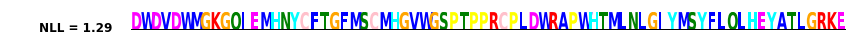

>seqprop_Basinhopping 1/0.01_0
DWDVDWMGKGQIEMHNYCFTGFMSCMHGVWGSPTPPRCPLDWRAPWHTMLNLGIYMSYFLQLHEYATLGRKE
final_loss_val = 1.1159


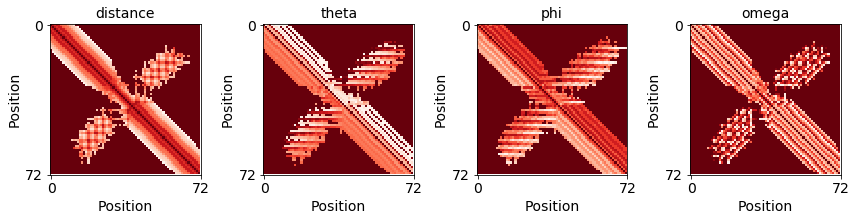

Experiment name = Basinhopping 1/0.1


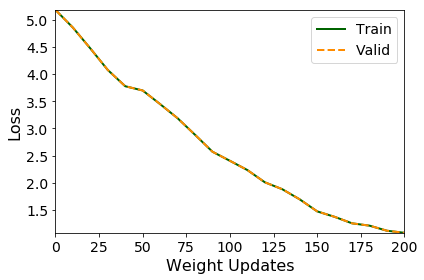

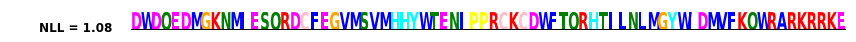

>seqprop_Basinhopping 1/0.1_0
DWDQEDMGKNMIESQRDCFEGVMSVMHHYWTENIPPRCKCDWFTQRHTILNLMGYWIDMVFKQWRARKRRKE
final_loss_val = 0.8544


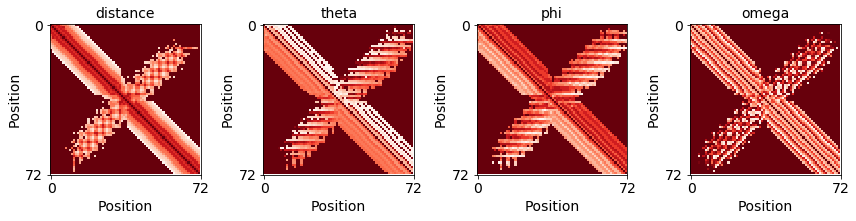

Experiment name = Basinhopping 1/1.0


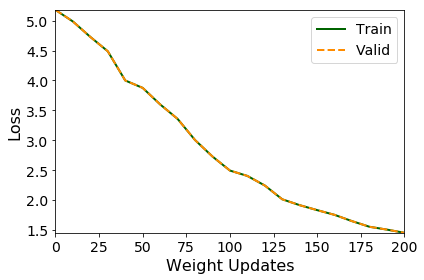

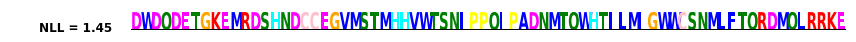

>seqprop_Basinhopping 1/1.0_0
DWDQDETGKEMRDSHNDCCEGVMSTMHHVWTSNIPPQIPADNMTQWHTILMIGWWCSNMLFTQRDMQLRRKE
final_loss_val = 0.9922


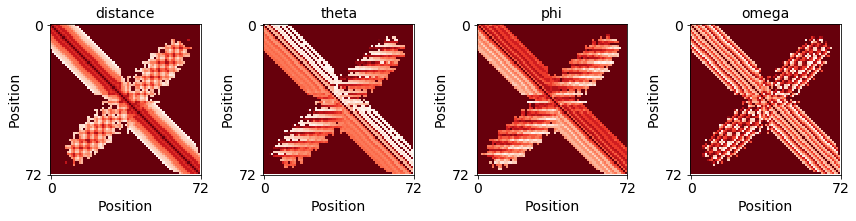

Experiment name = Sampled (Adam 0.001 0.9/0.999)


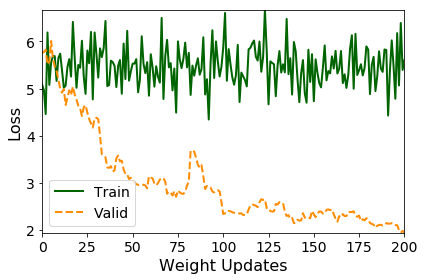

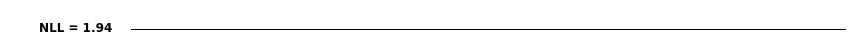

>seqprop_Sampled (Adam 0.001 0.9/0.999)_0
YGQENPDQYCPLYEWWVMIFVYIALMMRYLARESKHNNNPPPPPTPWYLWMILFQRAAQCMKHFEDKGNMFL
final_loss_val = 1.7462


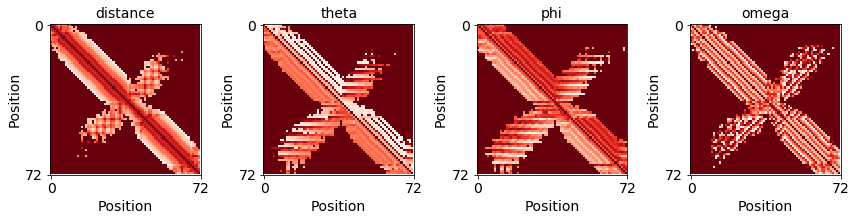

Experiment name = Sampled (Adam 0.01 0.5/0.9)


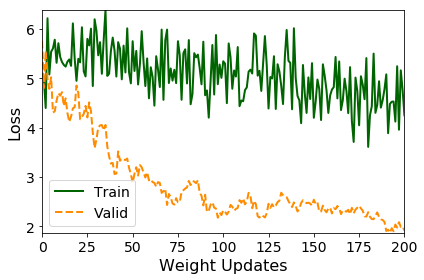

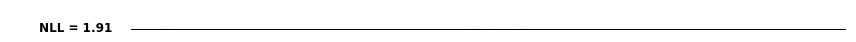

>seqprop_Sampled (Adam 0.01 0.5/0.9)_0
YSGDGDPVYCVIMIWWWAFFIFIILIIAYLRKKNKNKDPPDPPPPPDQWWMIMMQQMLAFLEYFSQCGNNCV
final_loss_val = 1.61


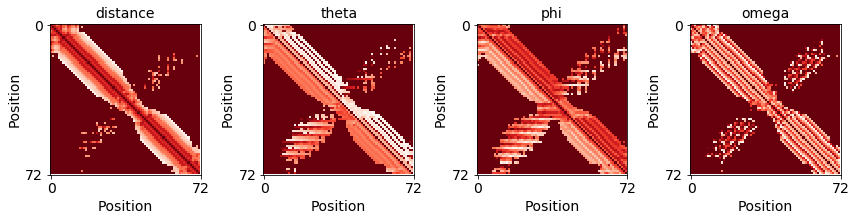

Experiment name = Sampled-IN (Adam 0.001 0.9/0.999)


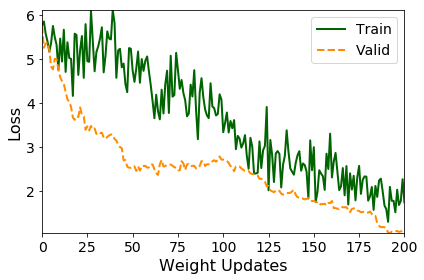

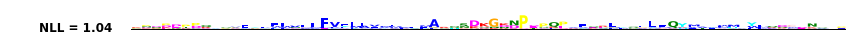

>seqprop_Sampled-IN (Adam 0.001 0.9/0.999)_0
KPDPDPPQYQVFFIFIVIIFVFIIVMFMLMARNSDKGKNPDPQPAFQRLYQILFQYMAWWMAYFQDCDNQFP
final_loss_val = 0.7226


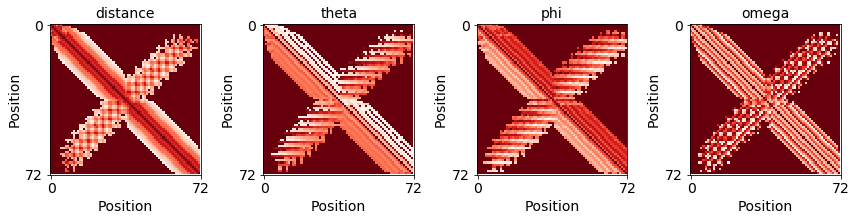

Experiment name = Sampled-IN (Adam 0.01 0.5/0.9)


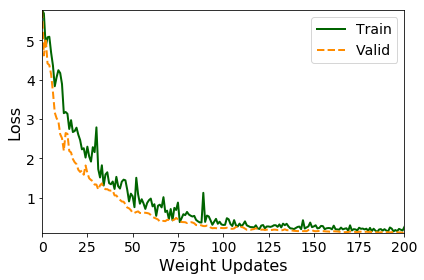

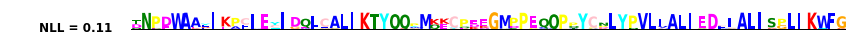

>seqprop_Sampled-IN (Adam 0.01 0.5/0.9)_0
TNPDWAAYIKPCIEYIDQLCALIKTYQQPMKKCPEEGMPPEQQPPYCNLYPVLIALIEDCIALISPLIKWFG
final_loss_val = 0.1553


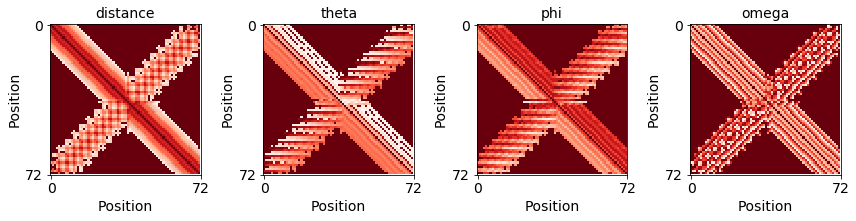

Experiment name = Sampled-IN 10x (Adam 0.01 0.5/0.9)


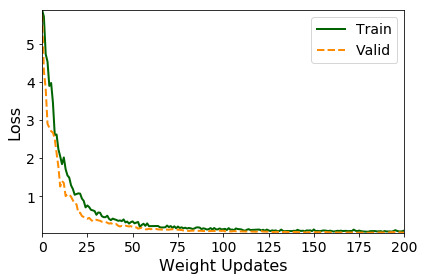

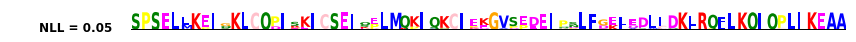

>seqprop_Sampled-IN 10x (Adam 0.01 0.5/0.9)_0
SPSELLKEIGKLCQPISKICSEIQELMQKIQKCIEKGVSEDEIPSLFGELEDLIDKLRQFLKQIQPLIKEAA
final_loss_val = 0.0478


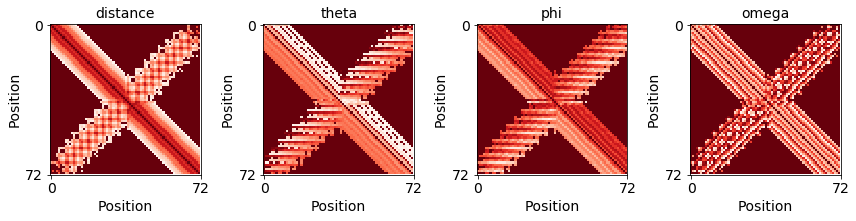

--- Comparison of loss convergence ---


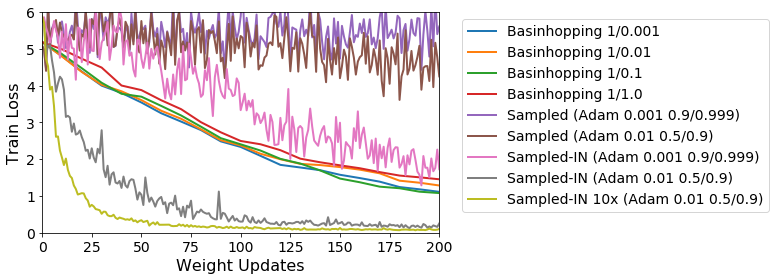

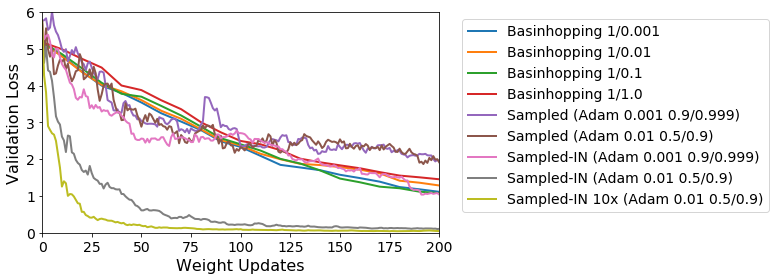

In [14]:
#Plot: Standard KL, All conditions, Mean across 5 trajectories

experiment_name_list = [
    'Basinhopping 1/0.001',
    'Basinhopping 1/0.01',
    'Basinhopping 1/0.1',
    'Basinhopping 1/1.0',
    
    'Sampled (Adam 0.001 0.9/0.999)',
    'Sampled (Adam 0.01 0.5/0.9)',
    
    'Sampled-IN (Adam 0.001 0.9/0.999)',
    'Sampled-IN (Adam 0.01 0.5/0.9)',
    
    'Sampled-IN 10x (Adam 0.01 0.5/0.9)'
]

plot_results(
    saved_predictor,
    result_dict,
    [t_pd, t_pt, t_pp, t_po],
    experiment_name_list,
    n_epochs,
    steps_per_epoch,
    loss_suffix='',
    fig_prefix="rosetta_TR005257_no_msa_kl_200_updates_5_seeds_no_drop_mean_", 
    save_figs=True,
    figsize=(11, 4),
    aggregate_mode='mean',
    legend_outside=True,
    min_loss_val=0.0,
    max_loss_val=6.0,
    plot_individual_trajectories=True
)


Experiment name = Basinhopping 1/0.001


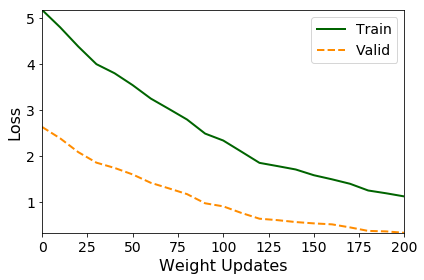

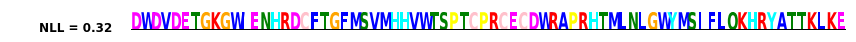

>seqprop_Basinhopping 1/0.001_0
DWDVDETGKGWIENHRDCFTGFMSVMHHVWTSPTCPRCECDWRAPRHTMLNLGWYMSIFLQKHRYATTKLKE
final_loss_val = 0.2058


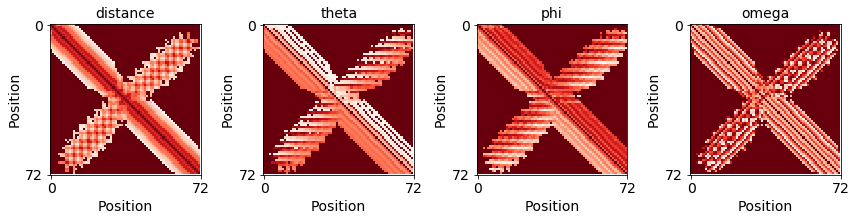

Experiment name = Basinhopping 1/0.01


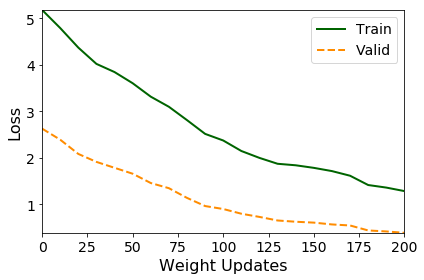

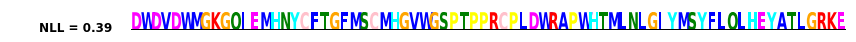

>seqprop_Basinhopping 1/0.01_0
DWDVDWMGKGQIEMHNYCFTGFMSCMHGVWGSPTPPRCPLDWRAPWHTMLNLGIYMSYFLQLHEYATLGRKE
final_loss_val = 0.3278


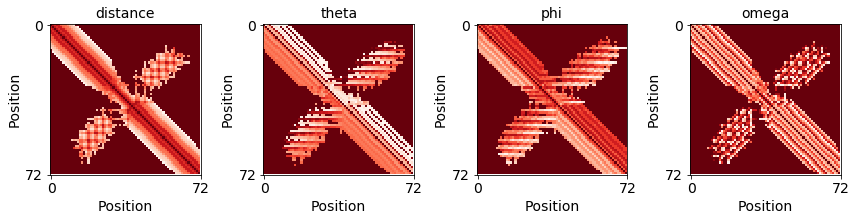

Experiment name = Basinhopping 1/0.1


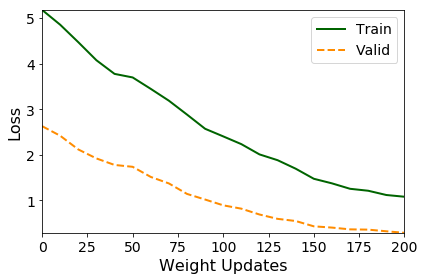

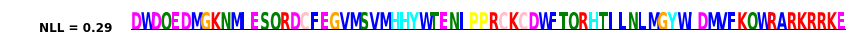

>seqprop_Basinhopping 1/0.1_0
DWDQEDMGKNMIESQRDCFEGVMSVMHHYWTENIPPRCKCDWFTQRHTILNLMGYWIDMVFKQWRARKRRKE
final_loss_val = 0.2012


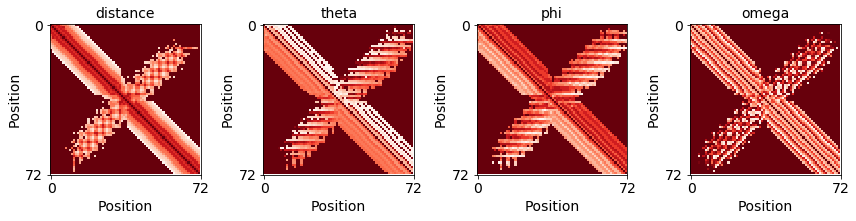

Experiment name = Basinhopping 1/1.0


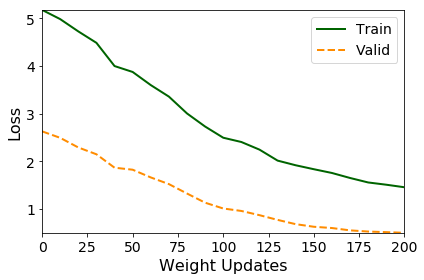

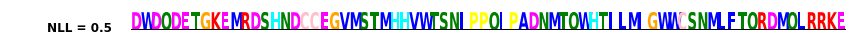

>seqprop_Basinhopping 1/1.0_0
DWDQDETGKEMRDSHNDCCEGVMSTMHHVWTSNIPPQIPADNMTQWHTILMIGWWCSNMLFTQRDMQLRRKE
final_loss_val = 0.2251


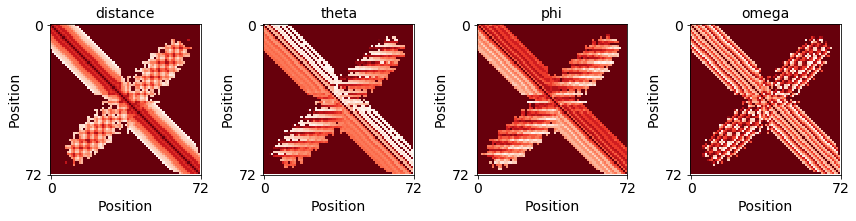

Experiment name = Sampled (Adam 0.001 0.9/0.999)


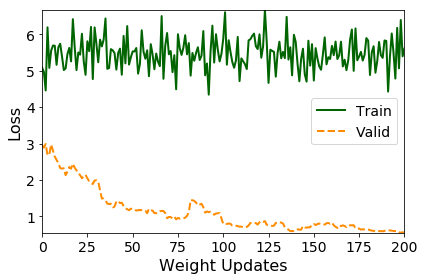

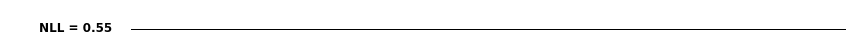

>seqprop_Sampled (Adam 0.001 0.9/0.999)_0
YGQENPDQYCPLYEWWVMIFVYIALMMRYLARESKHNNNPPPPPTPWYLWMILFQRAAQCMKHFEDKGNMFL
final_loss_val = 0.4841


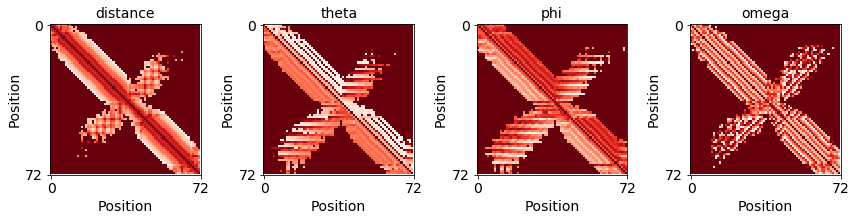

Experiment name = Sampled (Adam 0.01 0.5/0.9)


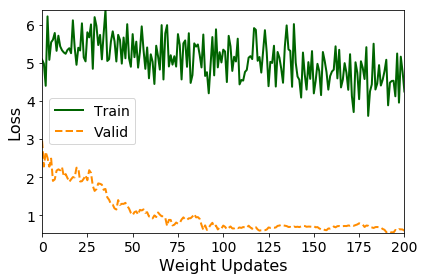

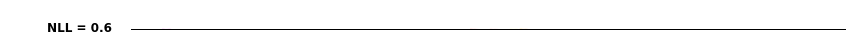

>seqprop_Sampled (Adam 0.01 0.5/0.9)_0
YSGDGDPVYCVIMIWWWAFFIFIILIIAYLRKKNKNKDPPDPPPPPDQWWMIMMQQMLAFLEYFSQCGNNCV
final_loss_val = 0.4639


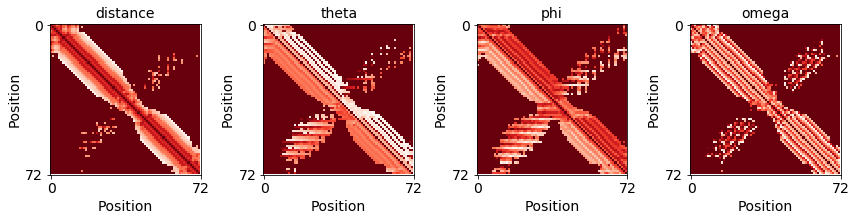

Experiment name = Sampled-IN (Adam 0.001 0.9/0.999)


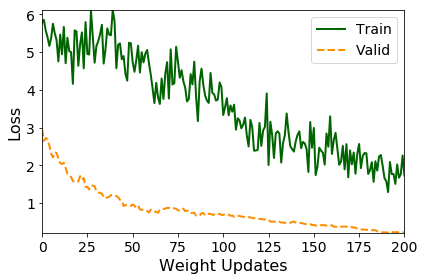

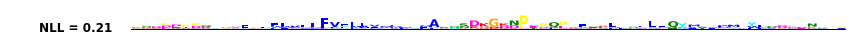

>seqprop_Sampled-IN (Adam 0.001 0.9/0.999)_0
KPDPDPPQYQVFFIFIVIIFVFIIVMFMLMARNSDKGKNPDPQPAFQRLYQILFQYMAWWMAYFQDCDNQFP
final_loss_val = 0.1745


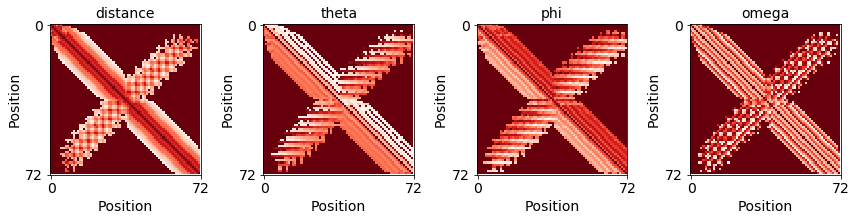

Experiment name = Sampled-IN (Adam 0.01 0.5/0.9)


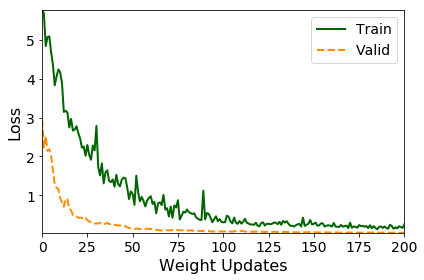

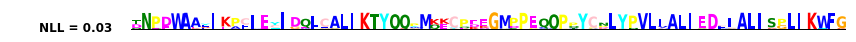

>seqprop_Sampled-IN (Adam 0.01 0.5/0.9)_0
TNPDWAAYIKPCIEYIDQLCALIKTYQQPMKKCPEEGMPPEQQPPYCNLYPVLIALIEDCIALISPLIKWFG
final_loss_val = 0.0524


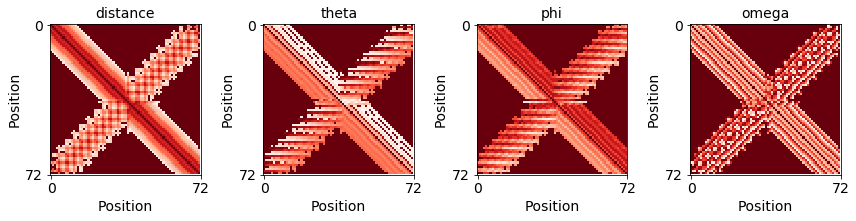

Experiment name = Sampled-IN 10x (Adam 0.01 0.5/0.9)


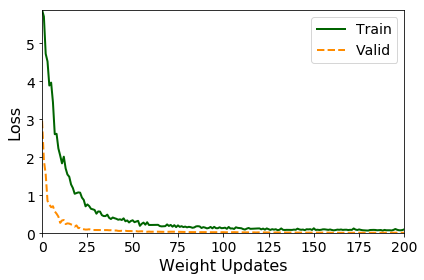

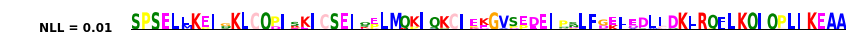

>seqprop_Sampled-IN 10x (Adam 0.01 0.5/0.9)_0
SPSELLKEIGKLCQPISKICSEIQELMQKIQKCIEKGVSEDEIPSLFGELEDLIDKLRQFLKQIQPLIKEAA
final_loss_val = 0.0122


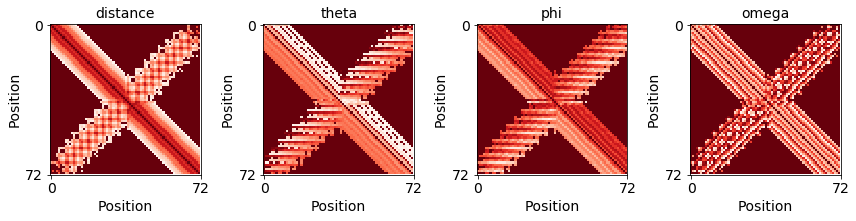

--- Comparison of loss convergence ---


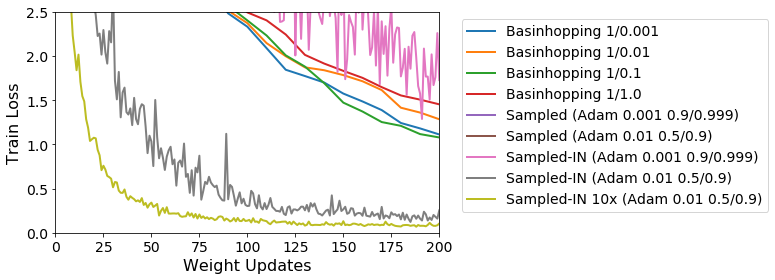

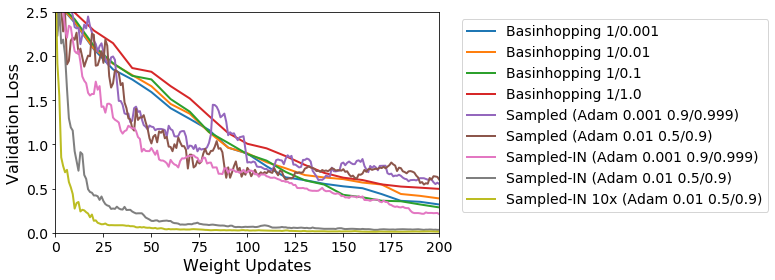

In [15]:
#Plot: Smooth KL, All conditions, Mean across 5 trajectories

experiment_name_list = [
    'Basinhopping 1/0.001',
    'Basinhopping 1/0.01',
    'Basinhopping 1/0.1',
    'Basinhopping 1/1.0',
    
    'Sampled (Adam 0.001 0.9/0.999)',
    'Sampled (Adam 0.01 0.5/0.9)',
    
    'Sampled-IN (Adam 0.001 0.9/0.999)',
    'Sampled-IN (Adam 0.01 0.5/0.9)',
    
    'Sampled-IN 10x (Adam 0.01 0.5/0.9)'
]

plot_results(
    saved_predictor,
    result_dict,
    [t_pd, t_pt, t_pp, t_po],
    experiment_name_list,
    n_epochs,
    steps_per_epoch,
    loss_suffix='_smooth_circular_kl',
    fig_prefix="rosetta_TR005257_no_msa_kl_200_updates_5_seeds_no_drop_smooth_kl_mean_", 
    save_figs=True,
    figsize=(11, 4),
    aggregate_mode='mean',
    legend_outside=True,
    min_loss_val=0.0,
    max_loss_val=2.5,
    plot_individual_trajectories=True
)
